In [1]:
from sktime.datasets import load_from_tsfile
from polyode import DATA_DIR
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_path = os.path.join(DATA_DIR,"CharacterTraj","CharacterTrajectories_TRAIN.ts")
train_x, train_y = load_from_tsfile(train_path)

In [44]:
def pad_irregular_characters(df):
    stacked_list = []
    max_len_stacked = 0
    for idx in range(df.shape[0]):
        max_len = np.max(np.array([len(df.iloc[idx]["dim_0"]), len(df.iloc[idx]["dim_1"]), len(df.iloc[idx]["dim_2"])])).astype(int)
        stacked_vec = np.stack([np.pad(df.iloc[idx]["dim_0"],(0,max_len-len(df.iloc[idx]["dim_0"]))), np.pad(df.iloc[idx]["dim_1"],(0,max_len-len(df.iloc[idx]["dim_1"]))), np.pad(df.iloc[idx]["dim_2"],(0,max_len-len(df.iloc[idx]["dim_2"])))],-1)
        if len(stacked_vec)>max_len_stacked:
            max_len_stacked = len(stacked_vec)
        stacked_list.append(stacked_vec)

    x = np.stack([np.pad(stack,((0,max_len_stacked-len(stack)),(0,0))) for stack in stacked_list])
    return x
x = pad_irregular_characters(train_x)

In [45]:
idxs = np.arange(len(x))[train_y=="2"]

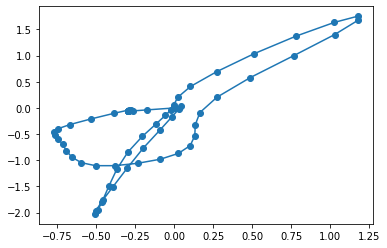

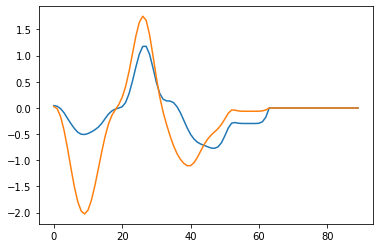

In [46]:
idx = idxs[3]
plt.plot()
plt.plot(x[idx,::2,0],x[idx,::2,1])
plt.scatter(x[idx,::2,0],x[idx,::2,1])
plt.show()
plt.figure()
plt.plot(x[idx,::2,0])
plt.plot(x[idx,::2,1])
plt.show()

In [82]:
train_y.astype(int)
map_dict = dict(zip(np.unique(train_y),np.arange(len(np.unique(train_y)))))
np.vectorize(map_dict.get)(train_y)

array([ 0,  0,  0, ..., 12, 12, 12])

In [83]:
x[idx,::2,0].shape

(90,)

In [3]:
from scipy.io import loadmat

In [50]:
train_path = os.path.join(DATA_DIR,"CharacterTraj","trajectories_train.mat")
test_path = os.path.join(DATA_DIR,"CharacterTraj","trajectories_xtest.mat")

train_file = loadmat(train_path,squeeze_me = True)
test_file = loadmat(test_path,  squeeze_me = True)

xtrain = train_file['xtrain']
ytrain = train_file['ytrain']
xtest = test_file['xtest']
# Transpose the data
xtrain_T = [seq.T for seq in xtrain]
xtest_T = [seq.T for seq in xtest]
# Find max length for data set normalization
max_len = 0
for i in range(len(xtrain_T)):
    if max_len < len(xtrain_T[i]):
        max_len = len(xtrain_T[i])
# 0-pad xtrain and xtest so they all have the same length
i = 0
xtrain_padded = []
while i < len(xtrain):
    attr_1 = np.hstack((xtrain[i][0], [0] * (max_len - len(xtrain[i][0]))))
    attr_2 = np.hstack((xtrain[i][1], [0] * (max_len - len(xtrain[i][1]))))
    attr_3 = np.hstack((xtrain[i][2], [0] * (max_len - len(xtrain[i][2]))))
    xtrain_padded.append([attr_1, attr_2, attr_3])
    i = i + 1

i = 0
xtest_padded = []
while i < len(xtest):
    attr_1 = np.hstack((xtest[i][0], [0] * (max_len - len(xtest[i][0]))))
    attr_2 = np.hstack((xtest[i][1], [0] * (max_len - len(xtest[i][1]))))
    attr_3 = np.hstack((xtest[i][2], [0] * (max_len - len(xtest[i][2]))))
    xtest_padded.append([attr_1, attr_2, attr_3])
    i = i + 1
    
# Training and validation data.
i = 0
x_data = np.zeros((len(xtrain_padded),len(xtrain_padded[0])*len(xtrain_padded[0][0])))
while i < len(xtrain_padded):
    temp = np.hstack((xtrain_padded[i][0],xtrain_padded[i][1]))
    temp = np.hstack((temp,xtrain_padded[i][2] ))
    x_data[i] = temp
    i = i + 1
# New test.
i = 0
x_test = np.zeros((len(xtest_padded),len(xtest_padded[0])*len(xtest_padded[0][0])))
while i < len(xtest_padded):
    temp1 = np.hstack((xtest_padded[i][0],xtest_padded[i][1]))
    temp1 = np.hstack((temp1,xtest_padded[i][2] ))
    x_test[i] = temp1
    i = i + 1
    
x = np.stack([np.stack([xdim for xdim in xtrain_]) for xtrain_ in xtrain_padded]).transpose(0,2,1)
xtest = np.stack([np.stack([xdim for xdim in xtest_]) for xtest_ in xtest_padded]).transpose(0,2,1)

In [60]:
len(xtest)

1429

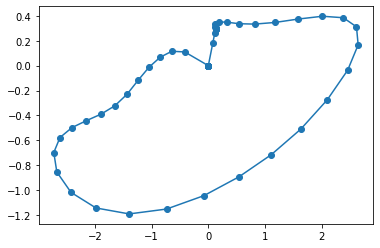

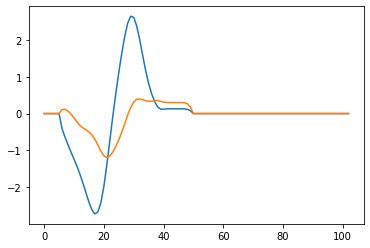

In [49]:
idx = idxs[3]
plt.plot()
plt.plot(x[idx,::2,0],x[idx,::2,1])
plt.scatter(x[idx,::2,0],x[idx,::2,1])
plt.show()
plt.figure()
plt.plot(x[idx,::2,0])
plt.plot(x[idx,::2,1])
plt.show()

In [4]:
import torch.nn as nn
import torch
path = os.path.join(DATA_DIR,"CharacterTraj","mixoutALL_shifted.mat")
file = loadmat(path,squeeze_me = True)

y = file["consts"]["charlabels"].item()
x = file["mixout"]

padded  = nn.utils.rnn.pad_sequence([torch.Tensor(x_.T) for x_ in x],batch_first = True)

min_len = np.min([x_.shape[1] for x_ in x])
cropped = np.stack([x_.T[:min_len] for x_ in x])

In [18]:
x = cropped
prop_obs = 0.8
t_len = x.shape[1]
N = x.shape[0]
xobs = torch.linspace(0,10,t_len) + 0.02
irregular_rate = 0.5
mask = np.random.binomial(1,irregular_rate,size = (N,t_len)).astype(bool)
x[~mask] = 0

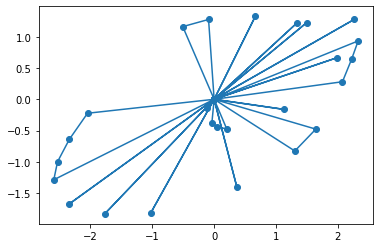

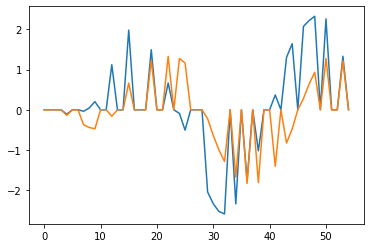

In [19]:
idx = 340
plt.plot()
plt.plot(x[idx,::2,0],x[idx,::2,1])
plt.scatter(x[idx,::2,0],x[idx,::2,1])
plt.show()
plt.figure()
plt.plot(x[idx,::2,0])
plt.plot(x[idx,::2,1])
plt.show()